In [564]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import math
from collections import Counter, OrderedDict
pd.set_option('display.max_columns',150)
plt.style.use('bmh')
from IPython.display import display
import copy
import warnings
warnings.filterwarnings("ignore")
from __future__ import print_function

# import of machine learning libraries
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestClassifier as RFR
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.svm import SVC, LinearSVC

In [565]:
def  read_data(file_path):
    return pd.read_csv(file_path)

In [566]:
file_path = 'all/train.csv'
test_data_file_path = 'all/test.csv'
titanic_data = read_data(file_path)
titanic_test_data = read_data(test_data_file_path)

In [567]:
passengerIds = titanic_test_data['PassengerId'].copy(deep = True)
passengerId_list = passengerIds.tolist()

In [568]:
var_of_interest = 'Survived'
titanic_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [569]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [570]:
null_fields = titanic_data.isnull().sum().sort_values(ascending=False)

Plot of null values for all the features in the data set.


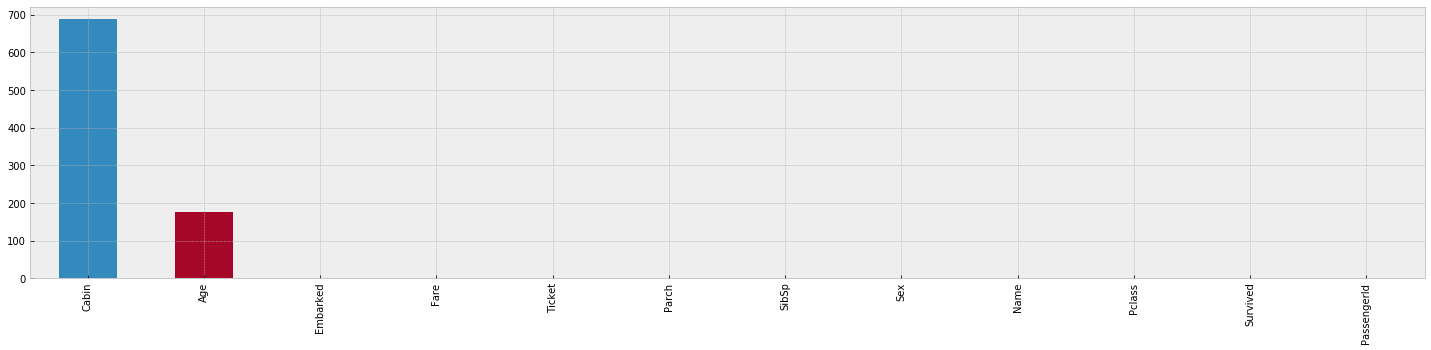

In [571]:
print("Plot of null values for all the features in the data set.")
null_fields.plot(kind='bar', figsize = (25,5))
plt.show()

In [572]:
def drop_unnecessary_columns(data):
    
    data = data.drop(columns = ['Name', 'Ticket','Cabin'])
    return data
    
titanic_data = drop_unnecessary_columns(titanic_data)
titanic_test_data = drop_unnecessary_columns(titanic_test_data)

In [573]:
def categorical_data_processing(data):
    
    data['Sex'] = data['Sex'].map({'male': 1, 'female': 2})
    data['Embarked'] = data['Embarked'].map({'S': 1, 'C': 2, 'Q' : 3})
    return data
    
titanic_data = categorical_data_processing(titanic_data)
titanic_test_data = categorical_data_processing(titanic_test_data)

In [574]:
def binning(data):
    labels = [1.0, 2.0, 3.0, 4.0, 5.0]
    print('age count: ',math.floor(data['Age'].count()))
    print('')
    age_bin_len = math.floor(data['Age'].count()/5)
    fare_bin_len = math.floor(data['Fare'].count()/5)
    print(age_bin_len)
    print(fare_bin_len)
    
    age_sorted_list = data['Age'].sort_values().tolist()
    fare_sorted_list = data['Fare'].sort_values().tolist()
    
    age_bins = [data['Age'].min(), age_sorted_list[age_bin_len], age_sorted_list[age_bin_len *2],
            age_sorted_list[age_bin_len*3], age_sorted_list[age_bin_len*4], 
            data['Age'].max()]
    
    fare_bins = [data['Fare'].min(), fare_sorted_list[fare_bin_len*1], fare_sorted_list[fare_bin_len *2],
            fare_sorted_list[fare_bin_len*3], fare_sorted_list[fare_bin_len*4], 
            data['Fare'].max()]
    
    print('')
    print('age_bins: ',age_bins)
    print('')
    print('fare_bins: ',fare_bins)
    
    #age_bins = [0, 20, 28, 29, 40, 80.0]
    data['Age'] = pd.cut(data['Age'], bins=age_bins, labels=labels)
    #data['Age'].fillna(3.0, inplace=True)

    #fare_bins = [0, 10, 20, 50, 100, 513]
    data['Fare'] = pd.cut(data['Fare'], bins=fare_bins, labels=labels)
    #data['Fare'].fillna(3.0, inplace=True)
    return data
    
titanic_data = binning(titanic_data)
titanic_test_data = binning(titanic_test_data)

age count:  714

142
178

age_bins:  [0.42, 19.0, 25.0, 31.0, 41.0, 80.0]

fare_bins:  [0.0, 7.8542, 10.5, 21.6792, 39.6875, 512.3292]
age count:  332

66
83

age_bins:  [0.17, 20.0, 25.0, 30.0, 42.0, 76.0]

fare_bins:  [0.0, 7.7958, 10.7083, 21.075, 45.5, 512.3292]


In [575]:
def removeBlankDataWithMeanMedianOrMode(data):

    data = data.replace("nan", np.nan)
    data = data.replace("NaN", np.nan)
    #imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    imp.fit(data)
    data_imputed = imp.transform(data)
    data = pd.DataFrame(data=data_imputed[:,:], index=[i for i in range(len(data_imputed))],
                         columns = data.columns.tolist())
    return data

titanic_data = removeBlankDataWithMeanMedianOrMode(titanic_data)
titanic_test_data = removeBlankDataWithMeanMedianOrMode(titanic_test_data)

In [576]:
def plot_correlation(x, y, figsize):
    fig, ax = plt.subplots(figsize= figsize)
    ax.set_title("Features")
    sns.barplot(x=x, y=y,  ax = ax)
    ax.set_ylabel("Correlation coefficients")
    plt.show()

    
def find_correlation(var_of_interest, data):
    
    df = copy.deepcopy(data)
    
    cols = [col for col in df.columns]
    cols.remove(var_of_interest)
    lbls, vals = [], []
    for col in cols:
        lbls.append(col)
        vals.append(np.corrcoef(df[col], df[var_of_interest])[0,1])
    correlations = pd.DataFrame({'features': lbls, 'corr_values': vals})
    correlations = correlations.sort_values(by='corr_values')
    print("")
    print("Features and their correlation values with target feature:")
    print(correlations)
    print("")
    return correlations

In [577]:
corrs = find_correlation(var_of_interest, titanic_data)


Features and their correlation values with target feature:
   corr_values     features
1    -0.338481       Pclass
4    -0.035322        SibSp
3    -0.033026          Age
0    -0.005007  PassengerId
5     0.081629        Parch
7     0.106811     Embarked
6     0.307509         Fare
2     0.543351          Sex



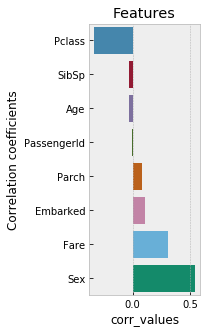

In [578]:
plot_correlation(corrs.corr_values, corrs['features'], figsize = (2,5))

In [579]:
def get_correlated_features(corrs):
    
    top_pos_corr_features = corrs.tail(2)['features']
    top_neg_corr_features = corrs.head(1)['features']
    top_corelated_features = np.concatenate((top_pos_corr_features.values, top_neg_corr_features.values), axis=0)

    top_corr_features_list = list(top_corelated_features)
    print("")
    print("Selected top correlated features for feature matrix:")
    print(top_corr_features_list)
    return top_corr_features_list

In [580]:
top_corr_features_list  = get_correlated_features(corrs)


Selected top correlated features for feature matrix:
['Fare', 'Sex', 'Pclass']


In [581]:
def get_feature_matrix(top_corr_features_list, data):
    
    correlated_data = data[top_corr_features_list].copy()
    feature_matrix = correlated_data.as_matrix()
    
    return feature_matrix

feature_matrix = get_feature_matrix(top_corr_features_list, titanic_data)
test_feature_matrix = get_feature_matrix(top_corr_features_list, titanic_test_data)

In [582]:
def get_labels(data):
    labels = list(data[var_of_interest])
    return labels

labels = get_labels(titanic_data)

In [583]:
def split_data_in_train_test(feature_matrix, labels):
    
    train_vectors, test_vectors, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size=0.1, random_state=0)

    print("")
    print("train_vectors.size(): ",len(train_vectors))
    print("test_vectors.size(): ",len(test_vectors))
    print("train_labels.size(): ",len(train_labels))
    print("test_labels.size(): ",len(test_labels))

    return train_vectors, test_vectors, train_labels, test_labels

In [584]:
train_vectors, test_vectors, train_labels, test_labels = split_data_in_train_test(feature_matrix, labels)


train_vectors.size():  801
test_vectors.size():  90
train_labels.size():  801
test_labels.size():  90


In [585]:
def gaussian_naive_bayes(train_vectors, test_vectors, train_labels, test_labels):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB()
    
    classifier_gnb_scores = cross_val_score(gnb, train_vectors, train_labels, cv=8)  
    print("")
    print('Gaussian naive bayes cross_val_scores: ', classifier_gnb_scores)
    y_pred = gnb.fit(train_vectors, train_labels)
    y_pred = gnb.predict(test_vectors) 

    gnb_accuracy = accuracy_score(test_labels, y_pred)
    print("")
    print('Gaussian naive bayes accuracy: ', gnb_accuracy)  
    print()
    print(classification_report(test_labels, y_pred))

In [586]:
gaussian_naive_bayes(train_vectors, test_vectors, train_labels, test_labels)



Gaussian naive bayes cross_val_scores:  [0.78217822 0.7029703  0.71       0.75       0.67       0.8
 0.82       0.7979798 ]

Gaussian naive bayes accuracy:  0.8111111111111111

             precision    recall  f1-score   support

        0.0       0.93      0.73      0.81        51
        1.0       0.72      0.92      0.81        39

avg / total       0.84      0.81      0.81        90



In [587]:
def svc_rbf(train_vectors, test_vectors, train_labels, test_labels):
    
    print("Training and testing on SVC with rbf kernel")
    classifier_rbf = SVC(kernel='rbf', gamma = 0.01)
    
    classifier_rbf_scores = cross_val_score(classifier_rbf, train_vectors, train_labels, cv=8)  
    print("")
    print('SVC RBF kernel cross_val_scores: ', classifier_rbf_scores)
    
    classifier_rbf.fit(train_vectors, train_labels)
    prediction_rbf = classifier_rbf.predict(test_vectors)
    classifier_rbf_accuracy = accuracy_score(test_labels, prediction_rbf)
    print("")
    print('SVC RBF kernel accuracy: ', classifier_rbf_accuracy)
    print()
    print(classification_report(test_labels, prediction_rbf))

In [588]:
svc_rbf(train_vectors, test_vectors, train_labels, test_labels)


Training and testing on SVC with rbf kernel

SVC RBF kernel cross_val_scores:  [0.77227723 0.75247525 0.79       0.79       0.76       0.77
 0.84       0.80808081]

SVC RBF kernel accuracy:  0.8

             precision    recall  f1-score   support

        0.0       0.79      0.88      0.83        51
        1.0       0.82      0.69      0.75        39

avg / total       0.80      0.80      0.80        90



In [589]:
def linear_svm(train_vectors, test_vectors, train_labels, test_labels):
    
    classifier_liblinear = LinearSVC()
    
    classifier_liblinear_scores = cross_val_score(classifier_liblinear, train_vectors, train_labels, cv=8) 
    print("")
    print('Linear SVC cross_val_scores: ', classifier_liblinear_scores)
    
    classifier_liblinear.fit(train_vectors, train_labels)
    prediction_liblinear = classifier_liblinear.predict(test_vectors)

    classifier_liblinear_accuracy = accuracy_score(test_labels, prediction_liblinear)
    print("")
    print('Linear SVC accuracy: ', classifier_liblinear_accuracy)
    print()
    print(classification_report(test_labels, prediction_liblinear))

In [590]:
linear_svm(train_vectors, test_vectors, train_labels, test_labels)


Linear SVC cross_val_scores:  [0.77227723 0.75247525 0.79       0.79       0.76       0.77
 0.84       0.80808081]

Linear SVC accuracy:  0.8

             precision    recall  f1-score   support

        0.0       0.79      0.88      0.83        51
        1.0       0.82      0.69      0.75        39

avg / total       0.80      0.80      0.80        90



In [591]:
def rfc(train_vectors, test_vectors, train_labels, test_labels):
    
    from sklearn.ensemble import RandomForestClassifier as RFR

    rfr = RFR()

    rfr_scores = cross_val_score(rfr, train_vectors, train_labels, cv=10) 
    print("")
    print('Random forest classifier crosss_val_scores: ', rfr_scores)

    rfr.fit(train_vectors,train_labels)
    y_pred = rfr.predict(test_vectors) 

    rfr_accuracy = accuracy_score(test_labels, y_pred)
    print("")
    print('Random forest classifier accuracy: ', rfr_accuracy)
    print()
    print(classification_report(test_labels, y_pred))

In [592]:
rfc(train_vectors, test_vectors, train_labels, test_labels)



Random forest classifier crosss_val_scores:  [0.71604938 0.79012346 0.75308642 0.875      0.8        0.825
 0.8125     0.775      0.82278481 0.79746835]

Random forest classifier accuracy:  0.8222222222222222

             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86        51
        1.0       0.90      0.67      0.76        39

avg / total       0.83      0.82      0.82        90



In [593]:
def find_best_svc_params():

    # Set the parameters by cross-validation
    tuning_params = [{'kernel': ['rbf'], 'gamma': [ 'auto', 1e-3, 1e-4],
                         'C': [1, 100, 500]},
                        {'kernel': ['linear'], 'C': [1, 100, 500]}]
    
    print("Tuning hyper-parameters for SVC")
    print()
    clf = GridSearchCV(SVC(), tuning_params, cv=5)
    clf.fit(train_vectors, train_labels)

    print("Best hyper-parameters found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Cross validation scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    return clf.best_params_

In [594]:
svc_best_params = find_best_svc_params()

Tuning hyper-parameters for SVC

Best hyper-parameters found on development set:

{'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}

Cross validation scores on development set:

0.793 (+/-0.010) for {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.622 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.622 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.804 (+/-0.017) for {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.785 (+/-0.039) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.785 (+/-0.039) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.804 (+/-0.017) for {'C': 500, 'gamma': 'auto', 'kernel': 'rbf'}
0.785 (+/-0.039) for {'C': 500, 'gamma': 0.001, 'kernel': 'rbf'}
0.785 (+/-0.039) for {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf'}
0.785 (+/-0.039) for {'C': 1, 'kernel': 'linear'}
0.785 (+/-0.039) for {'C': 100, 'kernel': 'linear'}
0.785 (+/-0.039) for {'C': 500, 'kernel': 'linear'}


In [595]:
def plot_validation_curve(estimator, X, y, title):

    from sklearn.model_selection import validation_curve

    param_range = np.logspace(-6, -1, 5)
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name="gamma", param_range=param_range,
        cv=10, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

In [596]:
def svc_best_params_classifier(train_vectors, test_vectors, train_labels, test_labels, best_params):
    
    if not best_params:
        classifier_svc = svm.SVC(kernel='rbf')
    else:
        kernel = best_params.get('kernel')
        if not best_params.get('gamma'):
            gamma = 'auto'
        else:
            gamma = best_params.get('gamma')
        C = best_params.get('C')
        classifier_svc = SVC(kernel=kernel, gamma = gamma, C = C)
        
    print()
    print("Best params used in SVC classifier for final classification:")
    print("kernel: ",kernel)
    print("gamma: ",gamma)
    print("C: ",C)
    
    title = "Validation Curves with (SVM, RBF kernel)"
    
    plot_validation_curve(classifier_svc, train_vectors, train_labels, title) 
    
    classifier_svc.fit(train_vectors, train_labels)
    y_pred = classifier_svc.predict(test_vectors)
    
    misclassified = np.where(np.asarray(test_labels) != y_pred)
    print()
    print("Misclassified examples indices in test vector:",misclassified)
    classifier_svc_accuracy = accuracy_score(test_labels, y_pred)
    
    print("")
    print('SVC RBF kernel accuracy: ', classifier_svc_accuracy)
    print()
    print(classification_report(test_labels, y_pred))

Training and testing on SVC with best params found from cross validation

Best params used in SVC classifier for final classification:
kernel:  rbf
gamma:  auto
C:  100


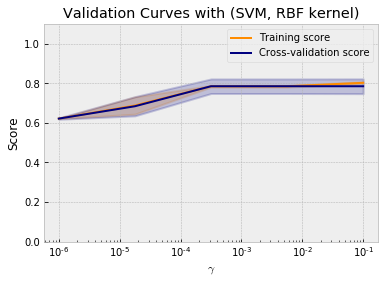


Misclassified examples indices in test vector: (array([ 5,  8, 15, 19, 33, 35, 40, 50, 51, 54, 59, 61, 71, 81, 82, 87],
      dtype=int64),)

SVC RBF kernel accuracy:  0.8222222222222222

             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86        51
        1.0       0.90      0.67      0.76        39

avg / total       0.83      0.82      0.82        90



In [597]:
print("Training and testing on SVC with best params found from cross validation")
svc_best_params_classifier(train_vectors, test_vectors, train_labels, test_labels, svc_best_params)

In [598]:
def find_best_rfc_params():

    from sklearn.ensemble import RandomForestClassifier
    rfc = RandomForestClassifier(random_state=0)

    param_grid = { 
    'n_estimators': [10, 500, 700]}
    
    print("Tuning hyper-parameters")
    print()
    clf = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 8)
    clf.fit(train_vectors, train_labels)

    print("Best hyper-parameters found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Cross validation scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    return clf.best_params_

In [599]:
rfc_best_params = find_best_rfc_params()


Tuning hyper-parameters

Best hyper-parameters found on development set:

{'n_estimators': 500}

Cross validation scores on development set:

0.798 (+/-0.057) for {'n_estimators': 10}
0.803 (+/-0.057) for {'n_estimators': 500}
0.798 (+/-0.057) for {'n_estimators': 700}


In [600]:
def rfc_classifier(train_vectors, test_vectors, train_labels, test_labels, best_params):
    
    print()
    if not best_params or len(best_params) == 0:
        print("No best params. Using default params.")
        rfr = RFR(n_estimators=500,random_state=0)
    else:
        n_estimators=best_params.get('n_estimators')
        print("Best params found for Random forest classifier - n_estimators: ",n_estimators)
        rfr = RFR(n_estimators = n_estimators, random_state=0)

    rfr.fit(train_vectors,train_labels)
    
    y_pred = rfr.predict(test_vectors) 

    misclassified = np.where(np.asarray(test_labels) != y_pred)
    print()
    print("Misclassified examples indices in test vector:",misclassified)
    
    rfr_accuracy = accuracy_score(test_labels, y_pred)
    print("")
    print('Random forest classifier accuracy after parameter tuning: ', rfr_accuracy)
    print()
    print(classification_report(test_labels, y_pred))
    print()
    return rfr

In [601]:
print("Training and testing Random forest classifier with best params found from cross validation")
rfc_classifier = rfc_classifier(train_vectors, test_vectors, train_labels, test_labels, rfc_best_params)

Training and testing Random forest classifier with best params found from cross validation

Best params found for Random forest classifier - n_estimators:  500

Misclassified examples indices in test vector: (array([ 5,  8, 15, 19, 33, 35, 40, 50, 51, 54, 59, 61, 71, 81, 82, 87],
      dtype=int64),)

Random forest classifier accuracy after parameter tuning:  0.8222222222222222

             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86        51
        1.0       0.90      0.67      0.76        39

avg / total       0.83      0.82      0.82        90




In [602]:
def get_final_test_labels(classifier, test_feature_matrix):
    y_pred = classifier.predict(test_feature_matrix) 
    return y_pred.tolist()

In [603]:
final_test_labels = get_final_test_labels(rfc_classifier, test_feature_matrix)

In [604]:
labels_list = list()
for val in final_test_labels:
    labels_list.append(int(val))

In [605]:
import csv

with open('titanic_result_labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
        
    passengerId_list.insert(0, 'PassengerId')
    labels_list.insert(0, 'Survived')
    rows = zip(passenger_id_list, labels_list)
    
    for row in rows:
        writer.writerow(row)